In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [11]:
# ============================
# 配置参数
# ============================

imageA_path = "/Users/baater/Desktop/大三上/挑战课题/lyc/datasets/yongzhou/DSC03201.JPG"  # 图像A的路径
imageB_path = "/Users/baater/Desktop/大三上/挑战课题/lyc/datasets/yongzhou/DSC03202.JPG"  # 图像B的路径
imageC_path = "/Users/baater/Desktop/大三上/挑战课题/lyc/datasets/yongzhou/DSC03203.JPG"  # 图像C的路径

# KNN 匹配参数
distance_ratio = 0.5  # KNN匹配的距离比率
ransac_threshold = 10   # RANSAC阈值
min_matches_required = 20  # 计算单应性矩阵所需的最小匹配点数量

# 图像增强参数
clahe_clip_limit = 2.0  # CLAHE对比度限制
clahe_tile_grid_size = (5, 5)  # CLAHE的网格大小

In [12]:
# ============================
# 函数定义
# ============================

# 1. 使用matplotlib显示图片
def show_image(image, title="Image"):
    """
    使用 Matplotlib 显示图像
    参数:
    - image: 待显示的图像，必须是 BGR 格式
    - title: 图像的标题，默认为 'Image'
    """
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # 转换为RGB格式
    plt.title(title)  # 设置图像标题
    plt.axis('off')  # 关闭坐标轴
    plt.show()  # 显示图像


In [13]:
# 2. 定义特征点检测和描述函数
def detectAndDescribe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced, -1, kernel)
    descriptor = cv2.SIFT_create(nOctaveLayers=5)
    (kps, des) = descriptor.detectAndCompute(sharpened, None)
    kps_float = np.float32([kp.pt for kp in kps])
    return (kps, kps_float, des)

In [14]:
def match_keypoints_flann(des1, des2):
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)  # 只添加单个匹配项

    return good_matches  # 返回的格式是 [m1, m2, ...]，每个 m 是 DMatch 对象




In [15]:
# 4. 绘制匹配结果函数
def draw_matches(imageA, kpsA, imageB, kpsB, good_matches):
    vis = cv2.drawMatches(imageA, kpsA, imageB, kpsB, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return vis


In [16]:
def stitch_images(center_image, align_image, center_kps_float, align_kps_float, matches, center_position=None):
    if len(matches) > min_matches_required:
        # 提取匹配点的坐标
        pts_center = np.float32([center_kps_float[m.queryIdx] for m in matches])
        pts_align = np.float32([align_kps_float[m.trainIdx] for m in matches])

        # 计算单应性矩阵
        H, _ = cv2.findHomography(pts_align, pts_center, cv2.RANSAC, ransac_threshold)

        height_center, width_center = center_image.shape[:2]
        height_align, width_align = align_image.shape[:2]

        if center_position is None:
            center_position = (width_center // 2, height_center // 2)

        canvas_size = (height_center * 2, width_center * 2)
        translation_dist = (canvas_size[1] // 4, canvas_size[0] // 4)
        
        H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]], dtype=np.float32)

        result = cv2.warpPerspective(center_image, H_translation, canvas_size)
        
        H_combined = H_translation @ H.astype(np.float32)
        warped_align = cv2.warpPerspective(align_image, H_combined, canvas_size)

        result = np.maximum(result, warped_align)
        
        return result
    else:
        print(f"未找到足够的匹配点（需要至少 {min_matches_required} 个）")
        return None


In [17]:
def create_canvas(images):
    heights = [img.shape[0] for img in images]
    widths = [img.shape[1] for img in images]

    total_width = sum(widths)
    max_height = max(heights)

    canvas = np.zeros((max_height, total_width, 3), dtype=np.uint8)

    x_offset = 0
    for img in images:
        canvas[0:img.shape[0], x_offset:x_offset + img.shape[1]] = img
        x_offset += img.shape[1]

    return canvas


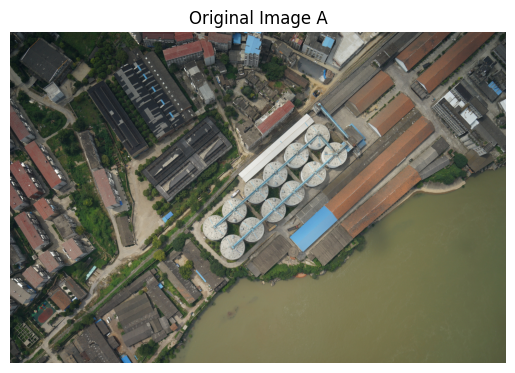

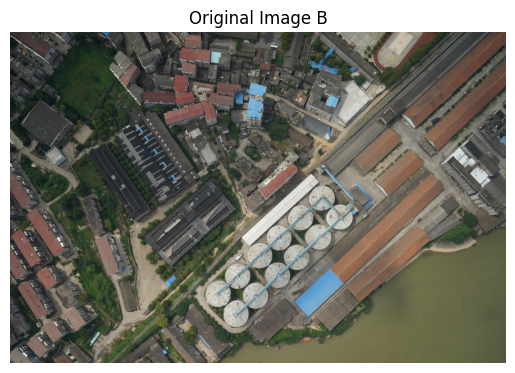

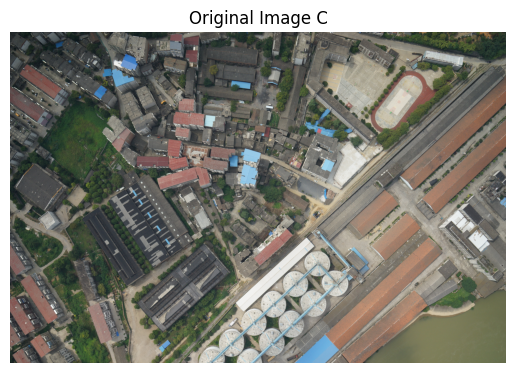

匹配到 A 和 B 4274 个特征点
匹配到 B 和 C 4715 个特征点


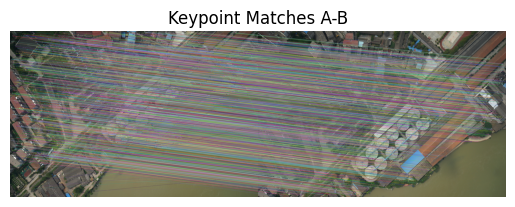

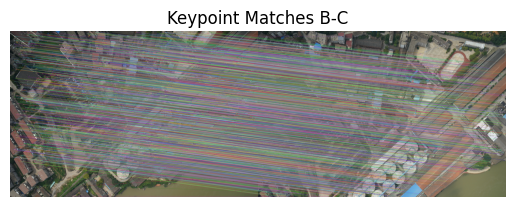

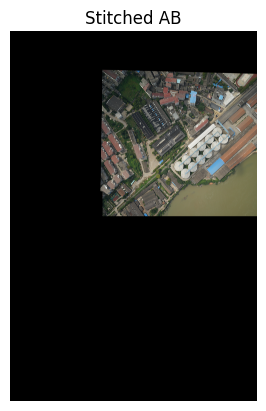

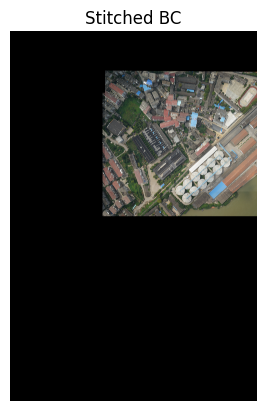

匹配到 stitchedAB 和 stitchedBC 3431 个特征点


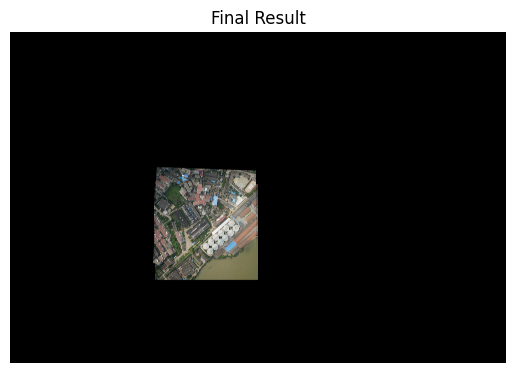

拼接结果已保存至：./output_FLANN/stitch_result_201_202_203.jpg


In [18]:
# ============================
# 读取图像并检查是否成功
# ============================

imageA = cv2.imread(imageA_path)
imageB = cv2.imread(imageB_path)
imageC = cv2.imread(imageC_path)

if imageA is None:
    print(f"无法加载图像A，请检查路径或文件格式：{imageA_path}")
if imageB is None:
    print(f"无法加载图像B，请检查路径或文件格式：{imageB_path}")
if imageC is None:
    print(f"无法加载图像C，请检查路径或文件格式：{imageC_path}")

if imageA is not None and imageB is not None and imageC is not None:
    show_image(imageA, 'Original Image A')
    show_image(imageB, 'Original Image B')
    show_image(imageC, 'Original Image C')

    (kpsA, kps_floatA, desA) = detectAndDescribe(imageA)
    (kpsB, kps_floatB, desB) = detectAndDescribe(imageB)
    (kpsC, kps_floatC, desC) = detectAndDescribe(imageC)

    # 匹配特征点
    good_matches_AB = match_keypoints_flann(desA, desB)
    print(f"匹配到 A 和 B {len(good_matches_AB)} 个特征点")
    
    good_matches_BC = match_keypoints_flann(desB, desC)
    print(f"匹配到 B 和 C {len(good_matches_BC)} 个特征点")

    # 绘制匹配结果
    vis_AB = draw_matches(imageA, kpsA, imageB, kpsB, good_matches_AB)
    show_image(vis_AB, 'Keypoint Matches A-B')

    vis_BC = draw_matches(imageB, kpsB, imageC, kpsC, good_matches_BC)
    show_image(vis_BC, 'Keypoint Matches B-C')

    # 1. 拼接 A 和 B（生成 stitchedAB）
    stitchedAB = stitch_images(imageA, imageB, kps_floatA, kps_floatB, good_matches_AB)
    show_image(stitchedAB, 'Stitched AB')  # 显示 A 和 B 的拼接结果

    # 2. 拼接 B 和 C（生成 stitchedBC）
    stitchedBC = stitch_images(imageB, imageC, kps_floatB, kps_floatC, good_matches_BC)
    show_image(stitchedBC, 'Stitched BC')  # 显示 B 和 C 的拼接结果

    # 最终拼接 stitchedAB 和 stitchedBC
    if stitchedAB is not None and stitchedBC is not None:
        # 检测拼接结果 stitchedAB 和 stitchedBC 的特征点
        (kps_stitchedAB, kps_float_stitchedAB, des_stitchedAB) = detectAndDescribe(stitchedAB)
        (kps_stitchedBC, kps_float_stitchedBC, des_stitchedBC) = detectAndDescribe(stitchedBC)

        # 匹配 stitchedAB 和 stitchedBC 的特征点
        good_matches_final = match_keypoints_flann(des_stitchedAB, des_stitchedBC)
        print(f"匹配到 stitchedAB 和 stitchedBC {len(good_matches_final)} 个特征点")

        # 3. 最终对齐 stitchedAB 和 stitchedBC，生成 final_result
        final_result = stitch_images(stitchedAB, stitchedBC, kps_float_stitchedAB, kps_float_stitchedBC, good_matches_final)
        
        # 显示和保存最终结果
        if final_result is not None:
            show_image(final_result, 'Final Result')  # 显示最终拼接结果

            # 保存拼接结果
            baseA = os.path.basename(imageA_path)[-7:-4]
            baseB = os.path.basename(imageB_path)[-7:-4]
            baseC = os.path.basename(imageC_path)[-7:-4]
            output_path = f'./output_FLANN/stitch_result_{baseA}_{baseB}_{baseC}.jpg'
            cv2.imwrite(output_path, final_result)
            print(f"拼接结果已保存至：{output_path}")
        else:
            print("最终拼接失败，无法生成结果。")
    else:
        print("无法拼接 A-B 或 B-C，拼接过程失败。")
